In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets
import time
from scipy.interpolate import griddata

np.set_printoptions(precision=2)

In [239]:
PATCH_SIZE = 5
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

SAFE_PATCH_REGION = lambda i, j, h, w : (slice(max(0, i - HALF_SIZE), min(h, i + HALF_SIZE + 1)), \
                                         slice(max(0, j - HALF_SIZE), min(w, j + HALF_SIZE + 1)))



def REGION_INTERSECT(ij1, r1, ij2, r2):
    # For region 1
    i1, j1 = ij1
    i2, j2 = ij2

    r1_y0, r1_x0, r1_y1, r1_x1 = r1[0].start, r1[1].start, r1[0].stop, r1[1].stop
    r2_y0, r2_x0, r2_y1, r2_x1 = r2[0].start, r2[1].start, r2[0].stop, r2[1].stop

    top = min(i1 - r1_y0, i2 - r2_y0)
    bottom = min(r1_y1 - i1, r2_y1 - i2)
    right = min(r1_x1 - j1, r2_x1 - j2)
    left = min(j1 - r1_x0, j2 - r2_x0)

    region1 = (slice(i1 - top, i1 + bottom), slice(j1 - left, j1 + right))
    region2 = (slice(i2 - top, i2 + bottom), slice(j2 - left, j2 + right))

    return region1, region2
    

MASK_COLOR = [0, 255, 0]

N_PATCH_MATCH_ITERS = 20

In [240]:
c1, s1 = (1, 1), (slice(1, 3), slice(0, 3))
c2, s2 = (5, 5), (slice(4, 6), slice(4, 7))

s1_new, s2_new = REGION_INTERSECT(c1, s1, c2, s2)

def pretty_print_2d_slice(s):
    print(f"start: {s.start}, stop: {s.stop}, step: {s.step}")

print("Slice 1:")
pretty_print_2d_slice(s1_new[0])
pretty_print_2d_slice(s1_new[1])

print("Slice 2:")
pretty_print_2d_slice(s2_new[0])
pretty_print_2d_slice(s2_new[1])


Slice 1:
start: 1, stop: 2, step: None
start: 0, stop: 3, step: None
Slice 2:
start: 5, stop: 6, step: None
start: 4, stop: 7, step: None


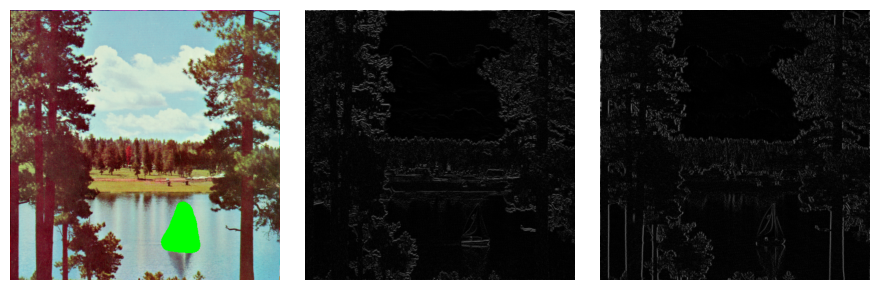

In [241]:
def in_bounds(r, c, h, w, dilated=False):
    starter = HALF_SIZE if dilated else 0
    return (r >= starter and r < h - starter) and (c >= starter and c < w - starter)
    
def masked_image(img, mask):
    return ~mask[:, :, np.newaxis] * img + (mask[:, :, np.newaxis]) * MASK_COLOR

image = Image.open('sailboat.tiff')
image = np.array(image)

height, width, channels = image.shape

mask = Image.open('sailboat_mask.png')
mask = np.mean(np.array(mask), axis=-1)
mask = mask < 255

grey_image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
gradient_y, gradient_x = np.abs(np.gradient(grey_image.astype(float)))
gradient = np.stack([gradient_x, gradient_y], axis=-1)

patch_counts = np.zeros_like(grey_image, dtype=int)

texture = np.empty(shape=(height, width, 2))

for i in range(height):
    for j in range(width):
        patch_region = SAFE_PATCH_REGION(i, j, height, width)
        cardinality = np.prod([slice.stop - slice.start for slice in patch_region])

        texture[i, j, 0] = 1/cardinality * np.sum(gradient[patch_region][..., 0])
        texture[i, j, 1] = 1/cardinality * np.sum(gradient[patch_region][..., 1])

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(masked_image(image, mask))
axs[0].axis('off')

axs[1].imshow(gradient_y, cmap='gray')
axs[1].axis('off')

axs[2].imshow(gradient_x, cmap='gray')
axs[2].axis('off')

plt.tight_layout()
plt.show()

Level 1: (516, 516, 3)
Level 2: (260, 260, 3)
Level 3: (132, 132, 3)
Level 4: (68, 68, 3)


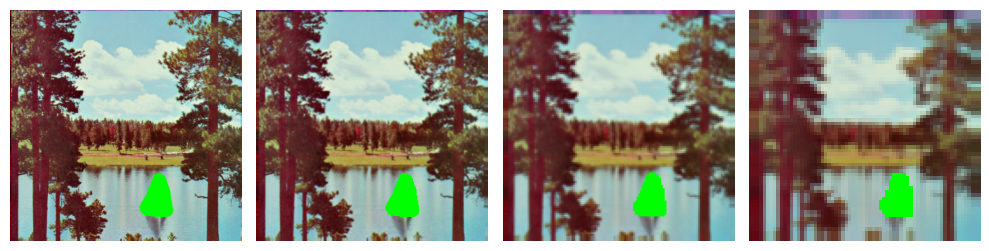

In [242]:
n_pyramid_levels = 4

image_pyramid = [image.copy()]
texture_pyramid = [texture.copy()]
mask_pyramid = [mask.copy()]

for i in range(1, n_pyramid_levels):
    # Apply Gaussian 3x3 kernel and downsample image
    next_level_image = ndimage.gaussian_filter(image_pyramid[-1], sigma=(1, 1, 0))[::2, ::2]
    image_pyramid.append(next_level_image)

    # Downsample texture map
    multiplier = 2 ** i
    next_level_texture = texture_pyramid[0][::multiplier, ::multiplier]
    texture_pyramid.append(next_level_texture)

    # Downsample the mask using (2x2) max pooling 
    next_level_mask = ndimage.maximum_filter(mask_pyramid[-1], size=(2, 2))[::2, ::2]
    mask_pyramid.append(next_level_mask)

padding_width = [(HALF_SIZE, HALF_SIZE), (HALF_SIZE, HALF_SIZE), (0, 0)]

for i in range(0, n_pyramid_levels):
    image_pyramid[i] = np.pad(image_pyramid[i], pad_width=padding_width, mode='edge')
    texture_pyramid[i] = np.pad(texture_pyramid[i], pad_width=padding_width, mode='edge')
    mask_pyramid[i] = np.pad(mask_pyramid[i], pad_width=padding_width[:-1], mode='edge') # TODO: fix this to be constant?

fig, axs = plt.subplots(1, len(image_pyramid), figsize=(10, 5))
for i, (img, msk) in enumerate(zip(image_pyramid, mask_pyramid)):
    print(f"Level {i+1}: {img.shape}")
    axs[i].imshow(masked_image(img, msk))
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [291]:
rho = 0.5
lam = 50
    
def partial_dist(image, texture, mask, patch_center_A, patch_center_B):
    image_h, image_w, _ = image.shape

    i_A, j_A = patch_center_A
    i_B, j_B = patch_center_B

    region_A = SAFE_PATCH_REGION(i_A, j_A, image_h, image_w)
    region_B = SAFE_PATCH_REGION(i_B, j_B, image_h, image_w)

    region_A_mask = mask[region_A][:, :, np.newaxis]
    region_A_image = image[region_A]
    region_A_texture = texture[region_A]

    region_B_mask = mask[region_B][:, :, np.newaxis]
    region_B_image = image[region_B]
    region_B_texture = texture[region_B]

    partial_patch_area = np.sum((~region_A_mask).astype(int))
    # if partial_patch_area == 0:
    #     print("A center: ", patch_center_A)
    #     print("B center: ", patch_center_B)

    masked_region_A_image = region_A_image * region_A_mask
    masked_region_A_texture = region_A_texture * region_A_mask

    masked_region_B_image = region_B_image * region_B_mask
    masked_region_B_texture = region_B_texture * region_B_mask

    ssd_image = np.sum(np.square(masked_region_A_image - masked_region_B_image))
    ssd_texture = np.sum(np.square(masked_region_A_texture - masked_region_B_texture))

    return 1/partial_patch_area * (ssd_image + lam * ssd_texture)

def dist(patch_center_A, patch_center_B):
    i_A, j_A = patch_center_A
    i_B, j_B = patch_center_B

    # if not in_bounds()

    region_A = image[PATCH_REGION(i_A, j_A)]
    region_B = image[PATCH_REGION(i_B, j_B)]

def ann(image, texture, mask, shift_map, distance_map, init=False, eroded_mask=None):
    dist_fn = dist if not init else partial_dist

    image_h, image_w, image_c = image.shape
    max_dimension = max(image_h, image_w)

    structure_element = np.ones((PATCH_SIZE, PATCH_SIZE))
    dilated_mask = ndimage.binary_dilation(mask, structure=structure_element)

    if init:
        dilated_boundary_mask = dilated_mask ^ eroded_mask
        plt.imshow(dilated_boundary_mask, cmap='gray')
        plt.show()
        # dilated_boundary_mask = ndimage.binary_dilation(boundary_mask, structure=np.ones((HALF_SIZE, HALF_SIZE)))

    offsets = {
        0: [np.array([0, 0], dtype=int), np.array([-1, 0], dtype=int), np.array([0, -1], dtype=int)],
        1: [np.array([0, 0], dtype=int), np.array([1, 0], dtype=int), np.array([0, 1], dtype=int)]
    }

    image_indices = {
        0: ([HALF_SIZE, image_h - HALF_SIZE, 1], [HALF_SIZE, image_w - HALF_SIZE, 1]),
        1: ([image_h - HALF_SIZE - 1, HALF_SIZE - 1, -1], [image_w - HALF_SIZE - 1, HALF_SIZE - 1, -1]),
    }
    
    # ANN Search
    for k in range(N_PATCH_MATCH_ITERS):
        r_range, c_range = image_indices[k%2]
        coord_ox = offsets[k%2]

        for r in range(*r_range):
            for c in range(*c_range):
                if init and not dilated_boundary_mask[r, c]: continue
                elif not init and not dilated_mask[r, c]: continue


                # Propagation stage
                curr_coord = np.array([r, c])

                min_shift, min_dist = shift_map[r, c], distance_map[r, c]
                
                for (shift_i, shift_j) in coord_ox:
                    correspondant_i, correspondant_j = r + shift_i, c + shift_j
                    
                    if not in_bounds(correspondant_i, correspondant_j, image_h, image_w, dilated=True): 
                        continue
                    
                    # candidate_shift_i, candidate_shift_j = shift_map[correspondant_i, correspondant_j]
                    candidate_i, candidate_j = curr_coord + shift_map[correspondant_i, correspondant_j]

                    if not in_bounds(candidate_i, candidate_j, image_h, image_w, dilated=True): 
                        continue

                    candidate_distance = dist_fn(image, texture, mask, curr_coord, (candidate_i, candidate_j))

                    if not dilated_mask[candidate_i, candidate_j] and candidate_distance < min_dist:
                        min_dist = candidate_distance
                        min_shift = shift_map[correspondant_i, correspondant_j]

                shift_map[r, c] = min_shift
                distance_map[r, c] = min_dist

                # print("curr", curr_coord)

                # candidate_centers = []
                # for ox in coord_ox:
                #     candidate_center = curr_coord + ox
                #     if in_bounds(*candidate_center, image_h, image_w, dilated=True):
                #         candidate_centers.append(candidate_center)
                # # print("cd", candidate_centers)

                # patch_distances = []
                # for (i, j) in candidate_centers:
                #     candidate_center = curr_coord + shift_map[i, j]

                #     if in_bounds(*candidate_center, image_h, image_w, dilated=True):
                #         patch_distances.append(dist_fn(image, texture, mask, curr_coord, candidate_center))
                #     else:
                #         patch_distances.append(float('inf'))
                # # print("pd", patch_distances)

                # # patch_distances = [
                # #     dist_fn(image, texture, mask, curr_coord, curr_coord + shift_map[i, j])
                # #     for (i, j) in candidate_centers
                # # ]
                # minimizer_idx = np.argmin(patch_distances)

                # q_i, q_j = candidate_centers[minimizer_idx]
                # shift_q_i, shift_q_j = shift_map[q_i, q_j]

                # if not mask[SAFE_PATCH_REGION(r + shift_q_i, c + shift_q_j, image_h, image_w)].any():
                #     shift_map[r, c] = shift_map[q_i, q_j]
                #     distance_map[r, c] = patch_distances[minimizer_idx]
                

                # Random search stage
                alpha = 1.0

                while alpha * max_dimension >= 1:
                    rand_uniform = np.random.uniform(-1, 1, 2)

                    offset = np.floor(max_dimension * alpha * rand_uniform).astype(np.int64)
                    q = curr_coord + shift_map[r, c] + offset

                    if in_bounds(*q, image_h, image_w, dilated=True):
                        q_distance = dist_fn(image, texture, mask, curr_coord, q)

                        if not (mask[SAFE_PATCH_REGION(*q, image_h, image_w)].any()) and \
                               (q_distance < distance_map[r, c]):
                                shift_map[r, c] += offset
                                distance_map[r, c] = q_distance
                    
                    alpha *= rho


def reconstruction(image, texture, mask, shift_map, distance_map, init=False, boundary_mask=None):
    if init: assert boundary_mask is not None

    image_h, image_w, image_c = image.shape

    sigmas = np.zeros_like(distance_map)

    for r in range(image_h):
        for c in range(image_w):
            if init and not boundary_mask[r, c]: continue
            elif not init and not mask[r, c]: continue

            region = SAFE_PATCH_REGION(r, c, image_h, image_w)
            
            # Unoccluded distances if initializing, otherwise all distances
            distances = distance_map[region]
            region_area = distances.shape[0] * distances.shape[1]

            q = 75

            if init:
                n_masked = np.sum(mask[region])
                q = 100 * (n_masked + 0.75 * (region_area - n_masked)) / region_area
                distances *= ~mask[region]
            
            sigmas[r, c] = np.percentile(distances, q)
    
    for r in range(image_h):
        for c in range(image_w):
            if init and not boundary_mask[r, c]: continue
            elif not init and not mask[r, c]: continue

            region = SAFE_PATCH_REGION(r, c, image_h, image_w)
            sigma_p = sigmas[r, c]

            scores = np.exp(-distance_map[region] / (2 * sigma_p ** 2))
            
            if init:
                scores *= ~mask[region]

            total_scores = np.sum(scores)
            shifts = shift_map[region]
            r_shifts = r + shifts[..., 0]
            c_shifts = c + shifts[..., 1]

            weighted_pixels = (scores[:, :, np.newaxis] * image[r_shifts, c_shifts]).reshape((-1, image_c))
            weighted_texture = (scores[:, :, np.newaxis] * texture[r_shifts, c_shifts]).reshape((-1, image_c))

            final_pixel_value = np.sum(weighted_pixels, axis=0) / total_scores
            final_texture_value = np.sum(weighted_texture, axis=0) / total_scores

            image[r, c] = final_pixel_value
            texture[r, c] = final_texture_value

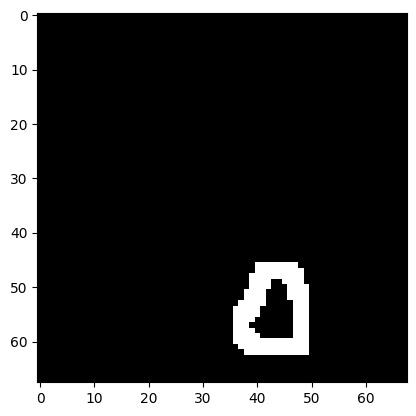

In [293]:
# Inpainting initialization with onion peel
coarse_mask = mask_pyramid[-1].copy()
eroded_mask = ndimage.binary_erosion(coarse_mask, structure=np.ones((3, 3)))
boundary_mask = eroded_mask ^ coarse_mask

structure_element = np.ones((PATCH_SIZE, PATCH_SIZE))
dilated_mask = ndimage.binary_dilation(coarse_mask, structure=structure_element)
dilated_boundary_mask = dilated_mask ^ eroded_mask


coarse_texture = texture_pyramid[-1].copy()
coarse_image = image_pyramid[-1].copy()

level_height, level_width, _ = coarse_image.shape

shift_map = np.zeros(shape=(level_height, level_width, 2), dtype=np.int64)
distance_map = np.zeros(shape=(level_height, level_width))

for r in range(HALF_SIZE, level_height - HALF_SIZE):
    for c in range(HALF_SIZE, level_width - HALF_SIZE):
        random_i, random_j = r, c
        # random_region = SAFE_PATCH_REGION(random_i, random_j, level_height, level_width)
        distance_map[r, c] = 0.0

        if dilated_boundary_mask[r, c]:
            while dilated_mask[random_i, random_j]:
                random_i, random_j = np.random.randint(HALF_SIZE, level_height - HALF_SIZE), np.random.randint(HALF_SIZE, level_width - HALF_SIZE)
                # random_region = SAFE_PATCH_REGION(random_i, random_j, level_height, level_width)
                distance_map[r, c] = partial_dist(coarse_image, coarse_texture, coarse_mask, (r, c), (random_i, random_j))
        
        shift_i, shift_j = random_i - r, random_j - c
        shift_map[r, c] = [shift_i, shift_j]

# while coarse_mask.any():
# plt.imshow(eroded_mask)
# plt.show()

# plt.imshow(boundary_mask)
# plt.show()

# plt.imshow(dte)
# plt.show()

# print(coarse_mask[SAFE_PATCH_REGION(46, 40, 64, 64)])
# print(coarse_mask[SAFE_PATCH_REGION(45, 40, 64, 64)])
# print(shift_map[46, 40])
# print(shift_map[45, 40])

ann(coarse_image, coarse_texture, coarse_mask,
    shift_map=shift_map,
    distance_map=distance_map,
    init=True,
    eroded_mask=eroded_mask)

# dte = np.exp(-distance_map)
# print(np.min(dte))
# plt.imshow(dte)
# plt.show()

# reconstruction(coarse_image, coarse_texture, coarse_mask,
#                shift_map=shift_map,
#                distance_map=distance_map,
#                init=True,
#                boundary_mask=boundary_mask)

# plt.imshow(coarse_image)
